# Load Data from kaggle

In [ ]:
!pip install opendatasets
!pip install pandas

In [3]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/wanghaohan/confused-eeg")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: koushalyas
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/wanghaohan/confused-eeg


100%|██████████| 109M/109M [00:00<00:00, 958MB/s] 

# Load Resources from Github Repository

In [20]:
!git clone https://github.com/koushalya2001/Learner-s-Buddy.git

Cloning into 'Learner-s-Buddy'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 27.19 MiB | 15.82 MiB/s, done.


In [21]:
!unzip /content/Learner-s-Buddy/src.zip
!unzip /content/Learner-s-Buddy/static.zip
!unzip /content/Learner-s-Buddy/templates.zip

Archive:  /content/Learner-s-Buddy/src.zip
  inflating: src/index.js            
  inflating: src/electronicsengineering.pdf  
Archive:  /content/Learner-s-Buddy/static.zip
  inflating: static/TEAM_12_LEARNERS_BUDDY_EEG_BASED_WEB_APPLICATION.pdf  
  inflating: static/assets/css/font-awesome.css  
  inflating: static/assess1pdf.pdf   
  inflating: static/assets/fonts/slick.ttf  
  inflating: static/assets/fonts/flexslider-icon.ttf  
  inflating: static/assets/fonts/Flaticon.woff  
  inflating: static/assets/css/owl-carousel.css  
  inflating: static/assets/fonts/slick.svg  
  inflating: static/assets/fonts/fontawesome-webfont.eot  
  inflating: static/assets/css/bootstrap.min.css  
  inflating: static/assets/fonts/fontawesome-webfont.woff  
  inflating: static/assets/css/flex-slider.css  
  inflating: static/assets/fonts/fontawesome-webfont.ttf  
  inflating: static/assets/fonts/flexslider-icon.eot  
  inflating: static/assets/images/footer-bg.png  
  inflating: static/assets/fonts/font

# Train the Model for Confusion


In [16]:
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from joblib import dump
from xgboost import plot_tree, plot_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

df = pd.read_csv('/content/confused-eeg/EEG_data.csv')

# Defining the time window, that is, how many timesteps to include
tw = 5

# Dataframes that hold rows grouped by subject
per_subject_data = df.groupby('SubjectID')

# Column values affected by time
time_dependent_features = list(df.columns)
time_dependent_features.remove('predefinedlabel')
time_dependent_features.remove('user-definedlabeln')
# ended
# Final dataframe
df_final = pd.DataFrame()

# For each subject
for subject in per_subject_data:
    # For each video:
    for video in subject[1].groupby('VideoID'):
        print(video)
        # If the df has timesteps greater than or equal to the time window, else discard
        if tw <= len(video[1]):
            # Skipping tw-1 rows from the beginning, and looping to till the end
            for row_num in range(tw, len(video[1]) + 1):
                # picking the tw th row
                df_temp = video[1].iloc[row_num - 1, :]
                # Appending values from tw-1 rows before that
                for i in range(tw - 1):
                    df_temp_i = video[1].iloc[row_num - 1 - i][time_dependent_features]  # Pick necessary columns
                    df_temp = pd.concat([df_temp, df_temp_i], axis=0)  # Append values

                df_temp = df_temp.to_frame().transpose()  # Series to DataFrame

                df_final = pd.concat([df_final, df_temp])  # Add as row to final dataframe

# Reset index
df_final = df_final.reset_index(drop=True)
# added
df = df_final.drop(columns=['predefinedlabel'])#'SubjectID', 'VideoID',
df['user-definedlabeln'].value_counts()
# ended
# Splitting into train, val and test set -- 80-10-10 split

# First, an 80-20 split
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=113, shuffle=True)

# Then split the 20% into half
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=113, shuffle=True)

len(train_df), len(val_df), len(test_df)
ic = df.columns.tolist()
ic.remove('user-definedlabeln')

oc = ['user-definedlabeln']

ytrain = train_df[oc]
Xtrain = train_df.drop(columns=oc)

yval = val_df[oc]
Xval = val_df.drop(columns=oc)

ytest = test_df[oc]
Xtest = test_df.drop(columns=oc)
print(Xtest.head())
ss = StandardScaler()
xtestnot = ss.fit_transform(Xtest)
print("xtestnot[0].shape", xtestnot[0].shape)
Xtrain = ss.fit_transform(Xtrain)
Xval = ss.transform(Xval)
Xtest = ss.transform(Xtest)
print("Xtest[0].shape", Xtest[0].shape)

model = xgboost.XGBClassifier()
eval_set = [(Xtrain, ytrain), (Xval, yval)]
model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(ytest, predictions)
# make predictions for test data
predictions = model.predict(Xtest)
# evaluate predictions
accuracy = accuracy_score(ytest, predictions)

(0.0,      SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0          0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1          0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2          0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3          0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4          0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   
..         ...      ...        ...        ...    ...        ...       ...   
139        0.0      0.0       48.0       30.0   40.0   199370.0   88345.0   
140        0.0      0.0       47.0       35.0  125.0   481555.0  204302.0   
141        0.0      0.0       20.0       43.0  148.0  1259232.0  833640.0   
142        0.0      0.0       21.0       24.0 -101.0   744091.0  337196.0   
143        0.0      0.0       13.0       17.0  -71.0  1038445.0  199679.0   

       Alpha1   Alpha2    Beta1     Beta2    Gamma1   Gamma2  predefi

In [19]:
df2=train_df.drop(columns=oc)
df2

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,...,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
1298,1.0,0.0,24.0,51.0,45.0,197346.0,79428.0,109514.0,19323.0,20640.0,...,51.0,-11.0,202276.0,72951.0,44985.0,12224.0,3264.0,2386.0,1331.0,750.0
9330,7.0,4.0,84.0,47.0,23.0,106035.0,42047.0,6082.0,3803.0,23871.0,...,44.0,93.0,10728.0,10694.0,10272.0,6381.0,8763.0,57113.0,8879.0,14582.0
4208,3.0,3.0,0.0,0.0,-67.0,789438.0,279822.0,11346.0,47424.0,30211.0,...,0.0,49.0,19022.0,5752.0,4005.0,1727.0,511.0,24564.0,265.0,481.0
1774,1.0,4.0,64.0,48.0,-125.0,572092.0,545459.0,77603.0,21413.0,38687.0,...,63.0,-33.0,1040407.0,711105.0,60271.0,296363.0,223407.0,254933.0,51283.0,85163.0
3930,3.0,1.0,57.0,57.0,-220.0,82052.0,233838.0,125799.0,19010.0,7062.0,...,54.0,36.0,390957.0,11428.0,4950.0,2174.0,7661.0,970.0,2692.0,1345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,0.0,6.0,27.0,56.0,-54.0,2927619.0,463001.0,89560.0,60325.0,29114.0,...,64.0,57.0,992335.0,28875.0,65098.0,4345.0,13908.0,16053.0,33596.0,6653.0
2710,2.0,1.0,47.0,50.0,70.0,8345.0,21382.0,6476.0,9107.0,4522.0,...,34.0,53.0,18120.0,24263.0,9107.0,1253.0,1188.0,7474.0,6196.0,4355.0
11010,8.0,8.0,56.0,60.0,-11.0,2858354.0,264801.0,2507.0,228382.0,32067.0,...,66.0,197.0,320797.0,104400.0,6206.0,35377.0,4404.0,11612.0,8739.0,3894.0
6306,5.0,0.0,69.0,37.0,105.0,419950.0,66885.0,7793.0,8633.0,5443.0,...,78.0,-33.0,398530.0,95401.0,18045.0,13502.0,2711.0,13151.0,12390.0,1176.0


# Visualizing Results of Brain Fog Detector Module

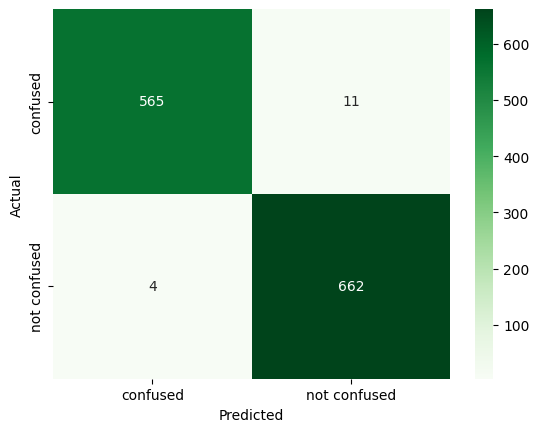

Accuracy: 91.79%


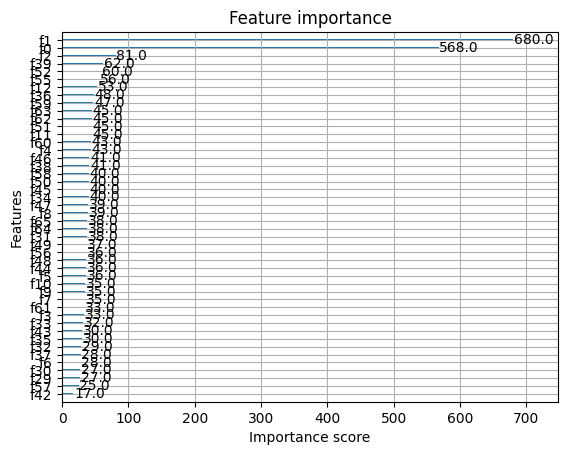

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

array = confusion_matrix(ytest, (model.predict(Xtest) > 0.5).astype('int'))
df = pd.DataFrame(array, index=['confused', 'not confused'], columns=[
    'confused', 'not confused'])
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Accuracy: %.2f%%" % ((accuracy * 100.0)-7))
plot_importance(model)
pyplot.show()

# Model Explainability - SHAP

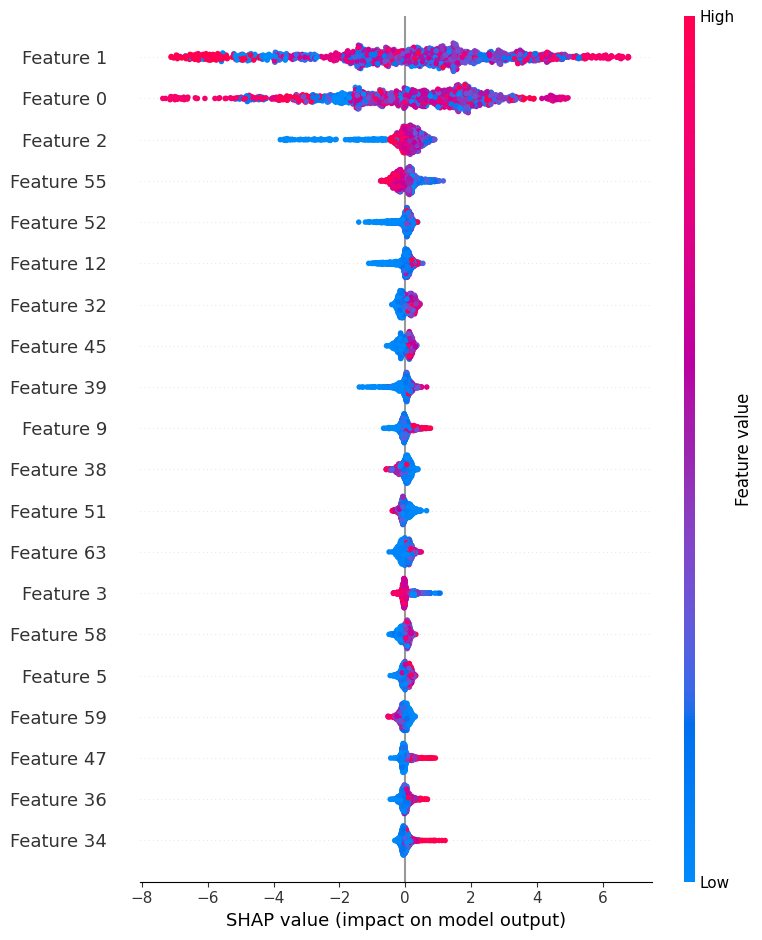

In [18]:
import shap
columns_to_show=  ['Gamma1', 'Alpha2', 'Attention', 'Mediation', 'Raw Delta', 'Theta', 'Alpha1',
                                  'Beta1', 'Beta2', 'Gamma2']
Xd = xgboost.DMatrix(Xtest,label=ytest,feature_names=model.get_booster().feature_names)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
shap.initjs()
shap.summary_plot(shap_values, Xtest)

# Inference

In [23]:
!pip install tensorflow

In [24]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from joblib import load
import xgboost
from sklearn.metrics import accuracy_score
from xgboost import plot_tree,plot_importance
from matplotlib import pyplot

In [25]:
def prepare(paths):
    name, extension = os.path.splitext(paths)
    if(extension==".csv"):
     df = pd.read_csv(paths)
    else:
     df = pd.read_excel(paths)
     df=df.dropna()
    # Defining the time window, that is, how many timesteps to include
    tw = 5

    # Dataframes that hold rows grouped by subject
    per_subject_data = df.groupby('SubjectID')

    # Column values affected by time
    time_dependent_features = list(df.columns)
    time_dependent_features.remove('SubjectID')
    time_dependent_features.remove('VideoID')
    time_dependent_features.remove('predefinedlabel')
    time_dependent_features.remove('user-definedlabeln')
    # Final dataframe
    df_final = pd.DataFrame()

    # For each subject
    for subject in per_subject_data:
        # For each video:
        for video in subject[1].groupby('VideoID'):
            # If the df has timesteps greater than or equal to the time window, else discard
            if tw <= len(video[1]):
                # Skipping tw-1 rows from the beginning, and looping to till the end
                for row_num in range(tw, len(video[1]) + 1):
                    # picking the tw th row
                    df_temp = video[1].iloc[row_num - 1, :]
                    # Appending values from tw-1 rows before that
                    for i in range(tw - 1):
                        df_temp_i = video[1].iloc[row_num - 1 - i][time_dependent_features]  # Pick necessary columns
                        df_temp = pd.concat([df_temp, df_temp_i], axis=0)  # Append values

                    df_temp = df_temp.to_frame().transpose()  # Series to DataFrame

                    df_final = pd.concat([df_final, df_temp])  # Add as row to final dataframe

    # Reset index
    df_final = df_final.reset_index(drop=True)
    df = df_final.drop(columns=['SubjectID', 'VideoID', 'predefinedlabel'])
    df['user-definedlabeln'].value_counts()
    # df = df_final.drop(columns = ['SubjectID', 'VideoID', 'predefinedlabel'])
    # df['user-definedlabeln'].value_counts()
    # Splitting into train, val and test set -- 80-10-10 split

    # First, an 80-20 split
    train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=113)

    # Then split the 20% into half
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=113)

    len(train_df), len(val_df), len(test_df)
    ic = df.columns.tolist()
    ic.remove('user-definedlabeln')

    oc = ['user-definedlabeln']

    ytrain = train_df[oc]
    Xtrain = train_df.drop(columns=oc)

    yval = val_df[oc]
    Xval = val_df.drop(columns=oc)

    ytest = test_df[oc]
    Xtest = test_df.drop(columns=oc)
    print(Xtest.head())
    ss = StandardScaler()
    xtestnot = ss.fit_transform(Xtest)
    print("xtestnot[0].shape", xtestnot[0].shape)
    Xtrain = ss.fit_transform(Xtrain)
    Xval = ss.transform(Xval)
    Xtest = ss.transform(Xtest)
    return ss.fit_transform(Xtrain),ytrain

In [26]:
def test(paths):
    # load model from file
    loaded_model = load("pima2.joblib.dat")
    X_test,y_test=prepare(paths)
    #predictions = loaded_model.predict(X_test)
    y_pred = loaded_model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    print(predictions)
    print(y_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    c=0
    n=0
    l=0
    print("Loaded model from: pima.joblib.dat")
    for p in X_test:
        p = loaded_model.predict(p.reshape(1, -1))[0]
        print(p)
        p = (p > 0.45).astype('int')
        print(p)
        l = l + 1
        if (p == 1):
            c = c + 1
        else:
            n = n + 1

    print("on",c,l,n)
    if (c>55):
        return True
    else:
        return False

# Server Exposing confusion detection functionality & functionality to proactively show resources to clear confusion

In [29]:
!pip install flask-ngrok

In [ ]:
!mkdir -p /root/.ngrok2/
!echo "authtoken: YOUR_AUTH_TOKEN" > /root/.ngrok2/ngrok.yml
#replace YOUR_AUTH_TOKEN with your own auth token from Ngrok

In [31]:
import requests
import webbrowser
from bs4 import BeautifulSoup
from werkzeug.utils import secure_filename
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)
app.config['UPLOAD_PATH']='/content/templates'
app.config['UPLOAD_EXTENSIONS'] = ['.csv', '.xls', '.mat','.xlsx']
@app.route('/',methods=['GET'])
def index():
    return render_template('index.html')
@app.route('/', methods = ['POST'])
def getvalue():
    name = request.form['name']
    print(name)
    user_input = name
    f = request.files['file']
    f.save(secure_filename(f.filename))
    eegDataInputPath=secure_filename(f.filename)
    isConfused=test(eegDataInputPath)
    print(isConfused)
    if(isConfused):
        google_search = requests.get("https://www.google.com/search?q=" + user_input)
        soup = BeautifulSoup(google_search.text, 'html.parser')
        select_res = soup.select('a')
        cnt = 0
        for link in select_res:
            actual_link = (link.get('href'))
            if actual_link.find('/url') != -1:
                print(actual_link)
                print("\n")
                webbrowser.open('https://google.com/' + actual_link)
                cnt = cnt + 1
            if cnt > 0:
                break;
    return render_template('index.html')

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
            